In [ ]:
import torch
import math
# set your target device


## Initialize and track the parameters using a list or dictionary

device ='cpu'

param_dict = {
    "W0": torch.rand(8,100,requires_grad=True,device = device), # torch.rand(10,20,requires_grad=True,device = device)
    "b0": torch.zeros(100,requires_grad=True,device = device),   #torch.zeros(20,requires_grad=True,device = device)
    "W1": torch.rand(100,1,requires_grad=True,device = device),  # torch.rand(20,1,requires_grad=True,device = device)
    "b1": torch.zeros(1,requires_grad=True,device = device),    # torch.zeros(1,requires_grad=True,device = device)
    }

#Nonlinearity = torch.tanh()
## Define the network
def my_nn(input, param_dict):
    h = torch.tanh(torch.matmul(input,param_dict['W0'])+ param_dict['b0'])
    output = (torch.matmul(h,param_dict['W1'])+ param_dict['b1'])
    return output,h

def absolute_loss(y_hat, y):
    return torch.abs(y_hat - y)

def initialize_nn(param_dict):
    for name, param in param_dict.items():
        param_dict[name] = torch.zeros_like(param)
        if "W" in name:
          param_dict[name] = param_dict[name].normal_(0, 1 / math.sqrt(param.size(0)))
        # turn on parameter gradients for parameters, and move them to device
        param_dict[name] = param_dict[name].to(device)
        param_dict[name].requires_grad = True


initialize_nn(param_dict)

torch.manual_seed(68)
x = torch.rand(1,10)
y = torch.rand(1)

print(x)
print(y)

tensor([[0.3991, 0.5521, 0.1004, 0.2844, 0.9998, 0.7077, 0.8031, 0.2066, 0.3589,
         0.8509]])
tensor([0.8753])


In [ ]:

y_hat,h = my_nn(x,param_dict)
Loss = absolute_loss (y_hat,y)
Loss.backward()

# Compute the gradients by hand

dL_dy_hat = torch.sign(y_hat - y)
dL_dw2 = dL_dy_hat * h
dL_db2 = dL_dy_hat
dL_da = dL_dy_hat * param_dict['W1']
dL_db1 = dL_da * (1 - h.pow(2))
dL_dW1 = x.transpose(0, 1).matmul(dL_da * (1 - h.pow(2)))

# Compute the difference between gradients
print('norm difference dL_dW1:', torch.linalg.norm(dL_dW1 - param_dict['W0'].grad))
print('norm difference dL_db1:', torch.linalg.norm(dL_db1.squeeze() - param_dict['b0'].grad))
print('norm difference dL_dw2:', torch.linalg.norm(dL_dw2.squeeze() - param_dict['W1'].grad))
print('norm difference dL_db2:', torch.linalg.norm(dL_db2 - param_dict['b1'].grad))


norm difference dL_dW1: tensor(6.5663e-08, grad_fn=<LinalgVectorNormBackward0>)
norm difference dL_db1: tensor(3.4409e-08, grad_fn=<LinalgVectorNormBackward0>)
norm difference dL_dw2: tensor(0., grad_fn=<LinalgVectorNormBackward0>)
norm difference dL_db2: tensor(0., grad_fn=<LinalgVectorNormBackward0>)


Best Learning Rate 0.0010


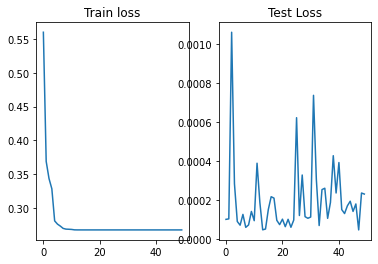

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load the dataset
data = fetch_california_housing()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.5, random_state=0)

# Normalize the data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)

X_train = (X_train - X_mean) / X_std
y_train = (y_train - y_mean) / y_std
X_test = (X_test - X_mean) / X_std
y_test = (y_test - y_mean) / y_std

# validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

batch_size = 8
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

initialize_nn(param_dict)

parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=0.1)

val_interval = 5
itter = 500
Train_loss = []
Train_Loss_Mse = []
Test_loss = []
Criterion = torch.nn.MSELoss()


val_loss_list = []

best_lr = None
best_val_loss = float('inf')


def my_zero_grad(param_dict):
    for _, param in param_dict.items():
        if param.grad is not None:
            param.grad.detach_()
            param.grad.zero_()

def Loss_func (y_hat,y):
  N = len(y)
  loss = sum(abs(y-y_hat))/N
  return loss


for epoch in range (50):
  train_loss = 0.0
  for i,(data,target) in enumerate(trainloader):
    #my_nn.train()
    data = data.float()
    target = target.float()
    optimizer.zero_grad()
    my_zero_grad(param_dict)

    output,_ = my_nn(data,param_dict)
    output = output.reshape(-1)
    Loss = Loss_func(output,target)
    Loss_MSE = Criterion(output,target)
    train_loss += Loss_MSE.item()

    Loss_MSE.backward()
    optimizer.step()
  train_loss /= len(trainloader)
  Train_loss.append(train_loss)

  # Evaluate the network on the validation set at regular intervals
  val_loss = 0.0
  with torch.no_grad():
      for data, target in valloader:
          output,_ = my_nn(data,param_dict)
          output = output.squeeze()
          loss = Loss_func(output, target)
          val_loss += loss.item()
      val_loss /= len(valloader)
  # Save the best learning rate based on validation loss

  if val_loss < best_val_loss:
      best_val_loss = val_loss
      for param_group in optimizer.param_groups:
          best_lr = param_group['lr']
  else :
      for param_group in optimizer.param_groups:
          param_group['lr'] = param_group['lr'] * 0.1   #updatinting Learning rate

for epoch in range(50):
  for t,(datas,targets) in enumerate(testloader):
    #my_nn.eval()
    test_loss = 0.0
    with torch.no_grad():
      my_zero_grad(param_dict)
      datas = datas.float()
      targets = targets.float()
      output,_ = my_nn(datas,param_dict)
      output = output.squeeze()
      Loss = Loss_func(output,targets)
      Loss_ = Criterion(output,targets)
      test_loss +=Loss_

  test_loss /=len(testloader)
  Test_loss.append(test_loss)

print('Best Learning Rate %.4f'%best_lr)
plt.subplot(121)
plt.plot(Train_loss)
plt.title('Train loss')
plt.subplot(122)
plt.plot(Test_loss)
plt.title('Test Loss')
plt.show()

### Question 2

In [ ]:
import torch
device='cpu'
cuda = torch.cuda.is_available()

def jacobian_backward_(x,W_dict,L):
  Hidden = []
  for i in range(1, L+1):
      W = W_dict[f'W{i}']
      if i ==1:
        h = torch.matmul(W,x)
        Hidden.append(h)
        h = torch.tanh(h)
        Hidden.append(h)
      else:
        h = torch.matmul(W,h)
        Hidden.append(h)
        h = torch.tanh(h)
        Hidden.append(h)
  h = torch.matmul(W_dict[f'WF'],h)
  dh = W_dict[f'WF']
  dh = torch.matmul(dh,torch.diagflat(1-Hidden[5].pow(2)))
  for i in range(L,0,-1):
    if i==1:
      dh = torch.matmul(dh,W_dict[f'W{i}'])
    else:
      dh = torch.matmul(torch.matmul(dh,W_dict[f'W{i}']),torch.diagflat(1-Hidden[2*i-3].pow(2)))
  return dh

Test Jacobian

In [ ]:
from torch.autograd.functional import jacobian

# Define the input values
D = 2
K = 30
P = 10
L = 3
device = 'cpu'
torch.manual_seed(68)
x = torch.randn(D,device = device)

# Define the dictionary of matrices

Ws = {
    'W1': torch.randn(K, D, requires_grad= True,device = device),
    'W2': torch.randn(K, K,requires_grad= True,device = device),
    'W3': torch.randn(K, K,requires_grad= True,device = device),
    'WF': torch.randn(P, K,requires_grad= True,device = device)
}

# Compute the Jacobian

Jacobian = jacobian_backward_(x, Ws,L=3)

print(Jacobian.shape)



F = lambda x: torch.matmul(Ws['WF'].to(device),torch.tanh(torch.matmul(Ws['W3'].to(device), torch.tanh(torch.matmul(Ws['W2'].to(device), torch.tanh(torch.matmul(Ws['W1'].to(device),x)))))))

J_true = jacobian(F, x).to(device)
print (J_true.shape)

print(torch.allclose(Jacobian, J_true))

torch.Size([10, 2])
torch.Size([10, 2])
True


### 2)b

In [ ]:
D = 2
K = 30
P = 10
L = 3

device = 'cpu'
torch.manual_seed(68)
x = torch.randn(D,device = device)

# Computing Forward Jacobian
def compute_jacobian_fwd(x, weights,L):
    D = x.shape[0]
    K = weights['W1'].shape[0]
    P = weights['WF'].shape[0]
    jacobian = torch.eye(D, dtype=torch.float, device = device, requires_grad=True)
    for i in range(1, L+1):
        w = weights[f'W{i}']
        x = torch.matmul(w, x)
        x = torch.tanh(x)
        jacobian = torch.matmul(torch.matmul(torch.diag_embed(1 - x**2), w), jacobian)
    jacobian = torch.matmul(weights['WF'], jacobian)
    return jacobian

# Compute Jacobian using both functions

jacobian2 = jacobian_backward_(x, Ws,L=3)
jacobian1 = compute_jacobian_fwd(x, Ws,L=3)

# Validate that the Jacobians are equal
torch.allclose(jacobian1, jacobian2, rtol=1e-05, atol=1e-08)

True

###2)C

In [ ]:
import time

def benchmark_jacobian(L, device):
    # Define test case
    D, K, P = 2, 30, 10
    x = torch.randn(D).to(device)
    weights = {
        'W1': torch.randn(K, D).to(device),
        'WF': torch.randn(P, K).to(device),
    }
    for i in range(2, L+1):
        weights[f'W{i}'] = torch.randn(K, K).to(device)

    # Compute Jacobian using backward mode automatic differentiation
    start_time = time.time()
    jacobian1 = jacobian_backward_(x, weights,L)
    end_time = time.time()
    time1 = end_time - start_time

    # Compute Jacobian using forward mode automatic differentiation
    start_time = time.time()
    jacobian2 = compute_jacobian_fwd(x, weights,L)
    end_time = time.time()
    time2 = end_time - start_time

    return time1, time2

In [ ]:
L_values = [3, 5, 10]

# Define devices to test
devices = {
    'cpu': torch.device('cpu'),
    'gpu': torch.device('cuda')
}

# Run benchmark for each combination of L and device
for L in L_values:
    print(f"L = {L}")
    for device_name, device in devices.items():
        print(f"Device: {device_name}")
        time1, time2 = benchmark_jacobian(L, device)
        print(f"Time (backward mode): {time1:.6f} seconds")
        print(f"Time (forward mode): {time2:.6f} seconds")

L = 3
Device: cpu
Time (backward mode): 0.000307 seconds
Time (forward mode): 0.000228 seconds
Device: gpu
Time (backward mode): 0.000690 seconds
Time (forward mode): 0.000537 seconds
L = 5
Device: cpu
Time (backward mode): 0.000359 seconds
Time (forward mode): 0.000377 seconds
Device: gpu
Time (backward mode): 0.000817 seconds
Time (forward mode): 0.000556 seconds
L = 10
Device: cpu
Time (backward mode): 0.000380 seconds
Time (forward mode): 0.000433 seconds
Device: gpu
Time (backward mode): 0.001001 seconds
Time (forward mode): 0.001411 seconds


###2)d


Theoretical speed comparisons of (b) and (c) depend on the size of the input x and the number of layers L. The backward mode implementation requires computing the Jacobian by performing forward passes for each of the D dimensions of x, followed by a backward pass to compute the gradient. This means that the backward mode implementation requires L forward passes and L backward passes, each involving K matrix multiplications of size KxD, KxK, or PxK, for a total of 2LK(KD+K^2+PK) operations.

The forward mode implementation requires only one forward pass of the entire network, followed by a backward pass to compute the Jacobian. This means that the forward mode implementation requires one forward pass involving L matrix multiplications of size KxK and one backward pass involving L matrix multiplications of size DxK, for a total of 2LK^2 + LDK operations.



### 3)a

We can build one neuron in input layer, three neuron in hidden layer and one neuron in output layer, with the following weight and biases.

h1(x) = ReLU(2x)

h2(x) = ReLU(4(x - 1/2))

h2(x) = ReLU(2(x - 1))

f(x) = h1(x) - h2(x) +h3(x) # output of f(x)

### 3)b

We can build one neuron in input layer, two neuron in hidden layer and one neuron in output layer, with the following weight and biases.

h1(x) = ReLU(x - s) # output of max(x - s, 0)

h2(x) = ReLU(-x - s) # output of max(-x - s, 0)

f(x) = h1(x) - h2(x) # output of f(x)

### 4)a,b

In [ ]:
import torch.nn as nn

class My_Model(nn.Module):
  def __init__(self,depth):
    super(My_Model, self).__init__()
    self.depth = depth
    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(784, 50))
    for i in range(depth - 1):
        self.layers.append(nn.Linear(50, 50))
    self.layers.append(nn.Linear(50, 10))

  def init_weights(self, d):
    if d=='xavier':
      for layer in self.layers:
         nn.init.xavier_uniform_(layer.weight)
    else:
      for layer in self.layers:
          nn.init.uniform_(layer.weight, -d, d)
          nn.init.zeros_(layer.bias)
  def forward(self, x):
    x = x.view(-1, 784)
    activations = []
    for layer in self.layers[:-1]:
        x = torch.tanh(layer(x))
        activations.append(x)
    logits = self.layers[-1](x)
    return activations, logits

### 4)c

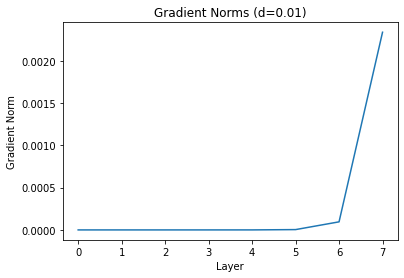

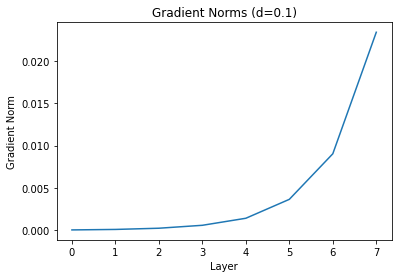

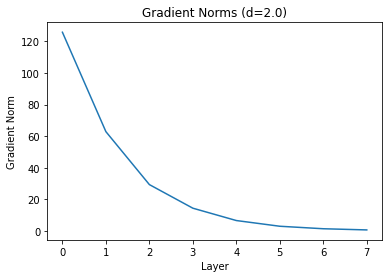

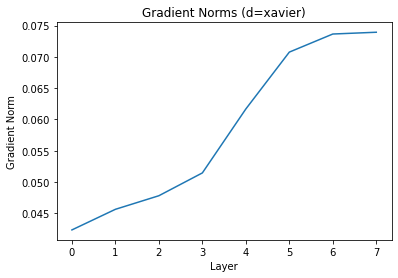

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

ds = [0.01, 0.1, 2.0, 'xavier']
model = My_Model(depth=8)

for d in ds:

    model.init_weights(d)

    # Forward and backward pass to compute gradient norms
    x, y = next(iter(train_loader))
    activations, logits = model(x)
    loss = F.cross_entropy(logits, y)
    gradient_norms = []
    for i, act in enumerate(activations):
        grads = torch.autograd.grad(loss, act, retain_graph=True)
        grad_norms = [g.norm() for g in grads]
        gradient_norms.append(grad_norms)
    # Plot gradient norms


    plt.plot(gradient_norms)
    plt.title(f"Gradient Norms (d={d})")
    plt.xlabel("Layer")
    plt.ylabel("Gradient Norm")
    plt.show()


###4)d

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epoch = 5

train_history = {
    'train_loss0': [],
    'train_acc_0': [],
    'train_loss1': [],
    'train_acc_1': [],
    'train_loss2': [],
    'train_acc_2': [],
    'train_loss3': [],
    'train_acc_3': [],
}

test_history = {
    'test_loss0': [],
    'test_acc_0': [],
    'test_loss1': [],
    'test_acc_1': [],
    'test_loss2': [],
    'test_acc_2': [],
    'test_loss3': [],
    'test_acc_3': [],
}

for i,d in enumerate(ds):
    model.init_weights(d)
    # Forward and backward pass to compute gradient norms
    for epoch in range(num_epoch):
      model.train()
      train_loss = 0.0
      correct = 0
      total = 0
      for data,target in train_loader:
        _, logits = model(data)
        loss = F.cross_entropy(logits, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(logits.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
      train_loss /= len(train_loader.dataset)
      train_accuracy = 100 * correct / total
      train_history[f'train_loss{i}'].append((train_loss)/len(train_loader))
      train_history[f'train_acc_{i}'].append(100 * correct / len(train_dataset))
      if d== 'xavier':
        print('train_accuracy %.4f for initialization Xavier and Epoch number %d' % (torch.tensor(np.array(train_history[f'train_acc_{i}'][epoch])),(epoch+1)))
      else:
        print('train_accuracy %.4f for initialization %.4f and Epoch number %d' % (torch.tensor(np.array(train_history[f'train_acc_{i}'][epoch])),d,(epoch+1)))
      with torch.no_grad():
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        for data,target in test_loader:
          _, logits = model(data)
          loss = F.cross_entropy(logits, target)
          test_loss += loss.item() * data.size(0)
          _, predicted = torch.max(logits.data, 1)
          total_test += target.size(0)
          correct_test += (predicted == target).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct_test / total_test
        test_history[f'test_loss{i}'].append((test_loss)/len(test_loader))
        test_history[f'test_acc_{i}'].append(100 * correct_test / len(test_dataset))
        if d== 'xavier':
          print('test_accuracy %.4f for initialization Xavier and Epoch number %d' % (torch.tensor(np.array(test_history[f'test_acc_{i}'][epoch])),(epoch+1)))
        else:
          print('test_accuracy %.4f for initialization %.4f and Epoch number %d' % (torch.tensor(np.array(test_history[f'test_acc_{i}'][epoch])),d,(epoch+1)))



train_accuracy 11.2083 for initialization 0.0100 and Epoch number 1
test_accuracy 11.3500 for initialization 0.0100 and Epoch number 1
train_accuracy 11.2367 for initialization 0.0100 and Epoch number 2
test_accuracy 11.3500 for initialization 0.0100 and Epoch number 2
train_accuracy 11.2367 for initialization 0.0100 and Epoch number 3
test_accuracy 11.3500 for initialization 0.0100 and Epoch number 3
train_accuracy 11.2367 for initialization 0.0100 and Epoch number 4
test_accuracy 11.3500 for initialization 0.0100 and Epoch number 4
train_accuracy 11.2367 for initialization 0.0100 and Epoch number 5
test_accuracy 11.3500 for initialization 0.0100 and Epoch number 5
train_accuracy 11.2150 for initialization 0.1000 and Epoch number 1
test_accuracy 11.3500 for initialization 0.1000 and Epoch number 1
train_accuracy 11.2367 for initialization 0.1000 and Epoch number 2
test_accuracy 11.3500 for initialization 0.1000 and Epoch number 2
train_accuracy 11.2367 for initialization 0.1000 and Ep

Plotting train and test accuracy

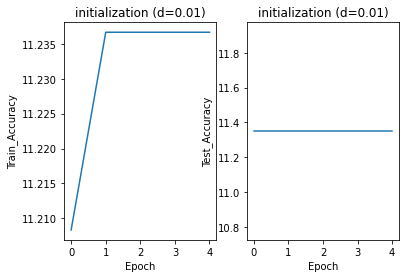

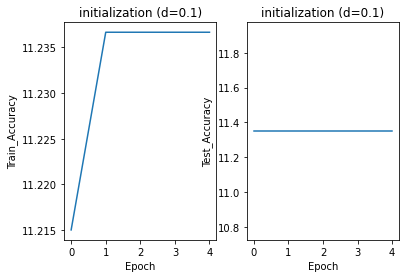

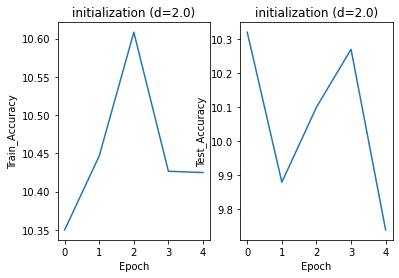

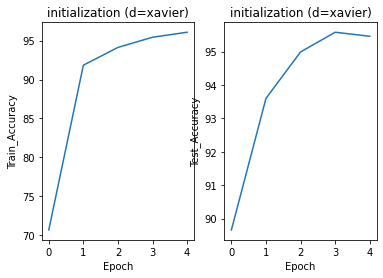

In [ ]:
for i,d in enumerate(ds):
  plt.subplot(121)
  plt.plot(train_history[f'train_acc_{i}'])
  plt.title(f"initialization (d={d})")
  plt.xlabel("Epoch")
  plt.ylabel("Train_Accuracy")
  plt.subplot(122)
  plt.plot(test_history[f'test_acc_{i}'])
  plt.title(f"initialization (d={d})")
  plt.xlabel("Epoch")
  plt.ylabel("Test_Accuracy")
  plt.show()


### 4)e

As you can see the accuracy increased significantly after initializing  with Xavier method, which we can see that importance of initialization in learning

###5

(a) To find the expression for the gradient, we first expand the squared norm:

L(X,w, y) = 1/2 * (Xw - y)^T (Xw - y)
= 1/2 * (w^T X^T X w - 2 y^T X w + y^T y)

Taking the derivative with respect to w, we get:

∇w L(X,w, y) = X^T X w - X^T y

(b) Starting with w0 and using a step size of α, the first iteration of gradient descent is:

w1 = w0 - α ∇w L(X,w0, y)
= w0 - α (X^T X w0 - X^T y)

The second iteration of gradient descent is:

w2 = w1 - α ∇w L(X,w1, y)
= w1 - α (X^T X w1 - X^T y)
= w0 - α (X^T X w0 - X^T y) - α (X^T X (w0 - α (X^T X w0 - X^T y)) - X^T y)
= w0 - α (X^T X w0 - X^T y) - α (X^T X w0 - X^T y) + α^2 X^T X (X^T X w0 - X^T y)
= w0 - 2α (X^T X w0 - X^T y) + α^2 X^T X X^T X w0 - α^2 X^T X X^T y

(c) The kth iteration of gradient descent is:

wk = wk-1 - α ∇w L(X,wk-1, y)
= wk-1 - α (X^T X wk-1 - X^T y)

Expanding this equation iteratively, we get:

wk = w0 - α (X^T X w0 - X^T y) - α (X^T X w1 - X^T y) - ... - α (X^T X wk-1 - X^T y)
= w0 - α (X^T X + X^T X + ... + X^T X) wk-1 + α (X^T y + X^T y + ... + X^T y)
= (I - α X^T X)^k w0 + α sum(X^T y)

(d) To show that gradient descent converges to the minimum in (a), we need to show that the iterates wk approach the minimizer of L(X,w, y) as k → ∞. We can do this by showing that the norm of the difference between wk and the minimizer approaches zero as k → ∞. Using the expression for wk from (c), we have:

||wk - argminw L(X,w, y)|| = ||(I - α X^T X)^k w0 - (I - α X^T X)^k argminw L(X,w, y)||
<= ||(I - α X^T X)^k|| ||w0 - argminw L(X,w, y)||

where the inequality follows from the triangle inequality. We can assume that XTX is positive definite and that α is chosen such that the spectral radius of I - αXTX is less than one, which ensures that ||(I - α X^T X)^k|| approaches zero as k → ∞. Therefore, the norm of the difference between wk



